<h2> Imports </h2>

In [8]:
import pandas as pd
from sklearn.linear_model import Ridge
from matplotlib import pyplot
from collections import Counter
import xgboost as xgb
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from scipy.stats import normaltest
from numpy.random import randn
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from numpy import *
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats.stats import pearsonr, spearmanr
from scipy import stats
import re
import warnings
warnings.filterwarnings("ignore")

In [9]:
# !pip install xgboost

<h2> Define Path of Dataset </h2> 

In [10]:
df = pd.read_csv('Test_manual.csv')
df.head()


#print(df.columns, 'df cols')

#drop NaN values
df.dropna(inplace=True)

#specify columns to drop
columnsToDrop = ['Date', 'Site Id','Year','Month','Day',
                 'G','G-1','G-2','G-3','G-4','G-5', 'H',
                 'H_CORRECTED', 'H_CORRECTED-1', 'H_CORRECTED-2', 'H_CORRECTED-3', 'H_CORRECTED-4',
                 'H_CORRECTED-5',
                 'NETRAD','NETRAD-1','NETRAD-2','NETRAD-3','NETRAD-4','NETRAD-5', 'LE',
                 'LE_CORRECTED', 'LE_CORRECTED(mm)-1', 'LE_CORRECTED(mm)-2', 'LE_CORRECTED(mm)-3', 'LE_CORRECTED(mm)-4',
                'LE_CORRECTED(mm)-5', 'C_BOWENS']


df = df.drop(columnsToDrop, axis = 1)
df.dropna(inplace=True)

#rename variables with spacing and under score for better proper namings
df.rename(columns={"Site Id_1": "Site_1", "Site Id_2": "Site_2",
                  "Site Id_3": "Site_3", "Site Id_4": "Site_4",
                  "Site Id_5": "Site_5", "Site Id_6": "Site_6"}, inplace=True)

#specify the output column
output_column = "LE_CORRECTED(mm)"

#specifying our X and Y
X = df.drop([output_column], axis=1)
#Y = df.drop(X.columns, axis = 1)
Y = df[output_column]

<h2> Describe the Dataset </h2>

In [11]:
report = df.describe() 
print(report)

                 WS          WS-1          WS-2          WS-3          WS-4  \
count  12074.000000  12074.000000  12074.000000  12074.000000  12074.000000   
mean       3.072717      3.069079      3.067051      3.067089      3.064733   
std        1.741018      1.749026      1.740372      1.745470      1.741261   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.758713      1.754495      1.756219      1.747823      1.744393   
50%        2.590402      2.586270      2.591926      2.590000      2.594010   
75%        4.047438      4.041292      4.040478      4.031726      4.031726   
max       12.714425     12.714425     12.714425     12.714425     12.714425   

               WS-5            RH          RH-1          RH-2          RH-3  \
count  12074.000000  12074.000000  12074.000000  12074.000000  12074.000000   
mean       3.071420     63.053613     63.808952     64.023894     64.050081   
std        1.744241     15.209466     15.564389    

<h2> Check Distribution of Columns by Plotting </h2> 

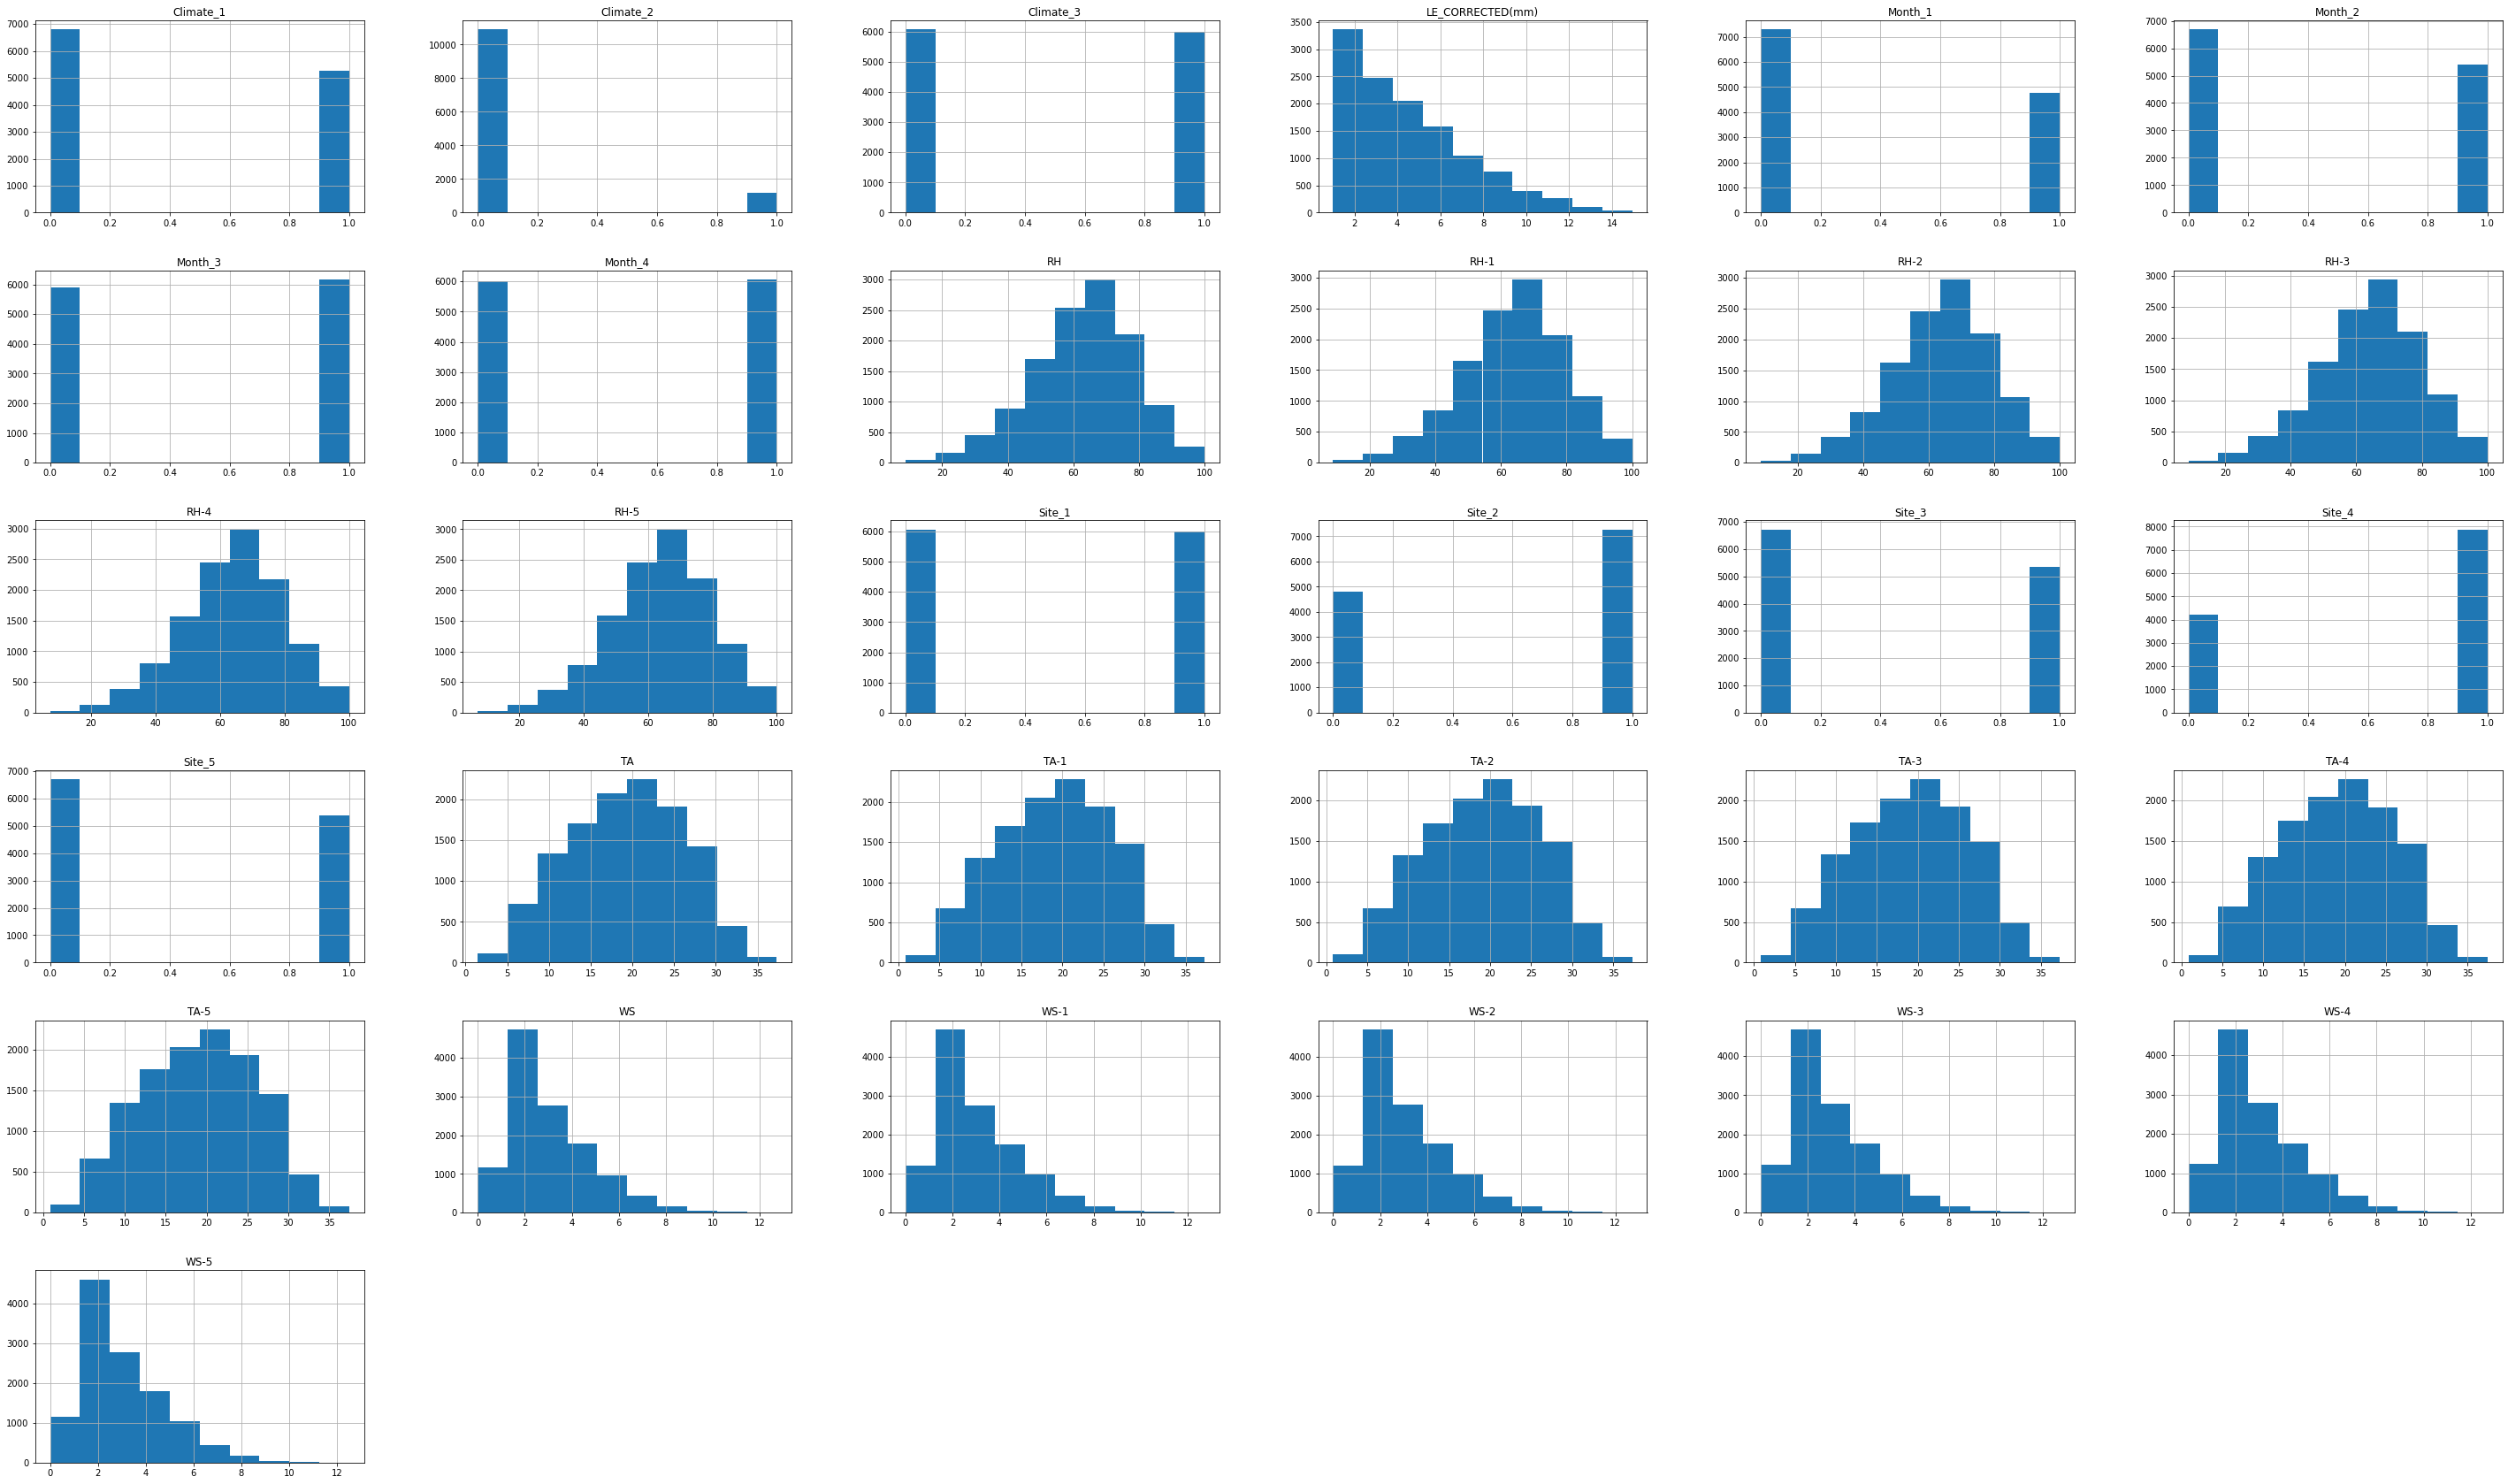

In [12]:
df = df.replace([np.inf, -np.inf], np.nan)
df.hist(figsize=(50, 30)) 
pyplot.show()

<h2> Helper Methods </h2> 

Yeo-Johnson: The Yeo-Johnson transformation is very similar to the Box-Cox but does not require the input variables to be strictly positive. In the package, the partial log-likelihood function is directly optimized within a reasonable set of transformation values (which can be changed by the user).

This transformation is typically done on the outcome variable using the residuals for a statistical model (such as ordinary least squares). Here, a simple null model (intercept only) is used to apply the transformation to the predictor variables individually. This can have the effect of making the variable distributions more symmetric.

If the transformation parameters are estimated to be very closed to the bounds, or if the optimization fails, a value of NA is used and no transformation is applied.

In [14]:
#checks if the input is gaussian by shapiro wilk test
def check_distribution_shapiro(col):
    stat, p = shapiro(col)
    alpha = 0.05
    if p > alpha:
        gaussian = True
    else:
        gaussian = False
        
    return gaussian

#checks if the input is gaussian by D’Agostino’s K^2 Test
def check_distribution_dagostino(col):
    stat, p = normaltest(col)
    alpha = 0.05
    if p > alpha:
        gaussian = True
    else:
        gaussian = False
        
    return gaussian

#splits data into train and test
def train_test_splitting(X,y,test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

#does suitable standardization
def standardization_needed(col, X):
    col = col.values.reshape(-1, 1)
    X = X.values.reshape(-1, 1)
    #checks if column has zero values
    if 0 not in col:
        col_trans = Standard(col,X)
        col_trans_pow = apply_power_trans(col_trans)
    else:
        #if there are zero values, applies MinMaxScaler 
        #check range of values
        col_trans = Min_Max(col,X)
        col_trans_pow = apply_power_trans(col_trans)          
    return  np.ravel(col_trans_pow)

def standardization_needed_manual(col, X, scaling):
    col = col.values.reshape(-1, 1)
    X = X.values.reshape(-1, 1)
    if scaling == 'None':
        col_trans_final = col
    if scaling == 'MinMax' :
        col_trans_final = Min_Max(col,X)
    if scaling == 'Standard' :
        col_trans_final = Standard(col,X)
    if scaling == 'Robust':
        col_trans_final = Robust(col,X)
    if scaling == 'MinMax + PowerTransform':
        col_trans = Min_Max(col,X)
        col_trans_final = apply_power_trans(col_trans)
    if scaling == 'Standard + PowerTransform':
        col_trans = Standard(col,X)
        col_trans_final = apply_power_trans(col_trans)
    return np.ravel(col_trans_final)
        
        
def Min_Max(col,X):
    if any(n < 0 for n in col):
        scaler = MinMaxScaler((-1,1))
    else: 
        scaler = MinMaxScaler((0,1))
    scaler.fit(X)
    col_trans = scaler.transform(col)
    return col_trans

def Standard(col,X):
    if 0 not in col:
        #if no zero values, apply StandardScaler
        scaler = StandardScaler()
        scaler.fit(X)
        col_trans = scaler.transform(col)
        return col_trans
    else: 
        print('column has 0 values, cannot apply standard scaling')
        return col
    
def Robust(col,X):
    scaler = RobustScaler()
    scaler.fit(X)
    col_trans = scaler.transform(col)
    return col_trans
    

def apply_power_trans(col_trans):
    if any(n <= 0 for n in col_trans):
    #if there are negative or zero values, applies yeo-johnson transform
        pt = PowerTransformer('yeo-johnson')
        col_trans_pow = pt.fit_transform(col_trans)
        #checks if column values are strictly positive
    elif all(n > 0 for n in col):
        #if values are strictly positive, applies box-cox transform
        pt = PowerTransformer('box-cox')
        col_trans_pow = pt.fit_transform(col_trans)
    return col_trans_pow

def apply_scaling(df, columns, X_train): 
    df_scaled = pd.DataFrame(columns=df.columns)
    for i in df.columns: 
        #checking if data is Gaussian
        if i in columns:
            if not check_distribution_shapiro(df[i]) and not check_distribution_dagostino(df[i]):
                print(str(i) + ' does not have a Gaussian distribution and will be scaled')
                #scaling data
                df_scaled[i] = standardization_needed(df[i], X_train[i])
            else: 
                df_scaled[i] = df[i]
                print(str(i) + ' has a gaussian distribution')
                
        else:
            df_scaled[i] = df[i]
    return df_scaled

def apply_scaling_manual(df, columns, X_train, scaling):
    iterator = 0
    if len(scaling) != len(columns):
        print("Please specify scaling for all columns listed")
        return
    else:
        df_scaled = pd.DataFrame(columns=columns)
        for i in columns: 
            #checking if data is Gaussian
            if not check_distribution_shapiro(df[i]) and not check_distribution_dagostino(df[i]):
                print(str(i) + ' does not have a Gaussian distribution and will be scaled')
                #scaling data
                df_scaled[i] = standardization_needed_manual(df[i], X_train[i], scaling[iterator])
                iterator = iterator + 1
            else: 
                df_scaled[i] = df[i]
                print(str(i) + ' has a gaussian distribution')
        return df_scaled

<h2> Automatic Scaling </h2>

In [15]:
#type desired col names
all_columns = list(X.columns)
#optional: type desired split size
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_splitting(X, Y, test_size=test_size)
X_train, X_valid, y_train, y_valid = train_test_splitting(X_train, y_train, test_size=test_size)
#standardize dataset
X_train_scaled = apply_scaling(X_train,all_columns,X_train)
X_test_scaled = apply_scaling(X_test,all_columns,X_train)
X_valid_scaled = apply_scaling(X_valid,all_columns,X_train)

WS does not have a Gaussian distribution and will be scaled
WS-1 does not have a Gaussian distribution and will be scaled
WS-2 does not have a Gaussian distribution and will be scaled
WS-3 does not have a Gaussian distribution and will be scaled
WS-4 does not have a Gaussian distribution and will be scaled
WS-5 does not have a Gaussian distribution and will be scaled
RH does not have a Gaussian distribution and will be scaled
RH-1 does not have a Gaussian distribution and will be scaled
RH-2 does not have a Gaussian distribution and will be scaled
RH-3 does not have a Gaussian distribution and will be scaled
RH-4 does not have a Gaussian distribution and will be scaled
RH-5 does not have a Gaussian distribution and will be scaled
TA does not have a Gaussian distribution and will be scaled
TA-1 does not have a Gaussian distribution and will be scaled
TA-2 does not have a Gaussian distribution and will be scaled
TA-3 does not have a Gaussian distribution and will be scaled
TA-4 does not 

<h2> Manual Scaling </h2>

Options are : 'MinMax', 'Standard', 'Robust', 'MinMax + PowerTransform', 'Standard + PowerTransform', 'None'

In [19]:
#type desired col names
all_columns = ['WS', 'RH', 'TA', output_column]
#type X col names (features)
X_cols = ['WS', 'RH', 'TA']
#type Y col names (predicted output)
Y_cols = [output_column]
#type the scaling type for each column
scaling = ['MinMax', 'Standard', 'Robust', 'MinMax + PowerTransform', 'Standard + PowerTransform']
#optional: type desired split size
test_size = 0.2
Y = df[Y_cols]
X = df[X_cols]
X_train, X_test, y_train, y_test = train_test_splitting(X,Y,test_size=test_size)
df_scaled_manual = apply_scaling_manual(df, all_columns, X_train, scaling)

Please specify scaling for all columns listed


<h2> View Results</h2>

<h3> Before Scaling </h3>

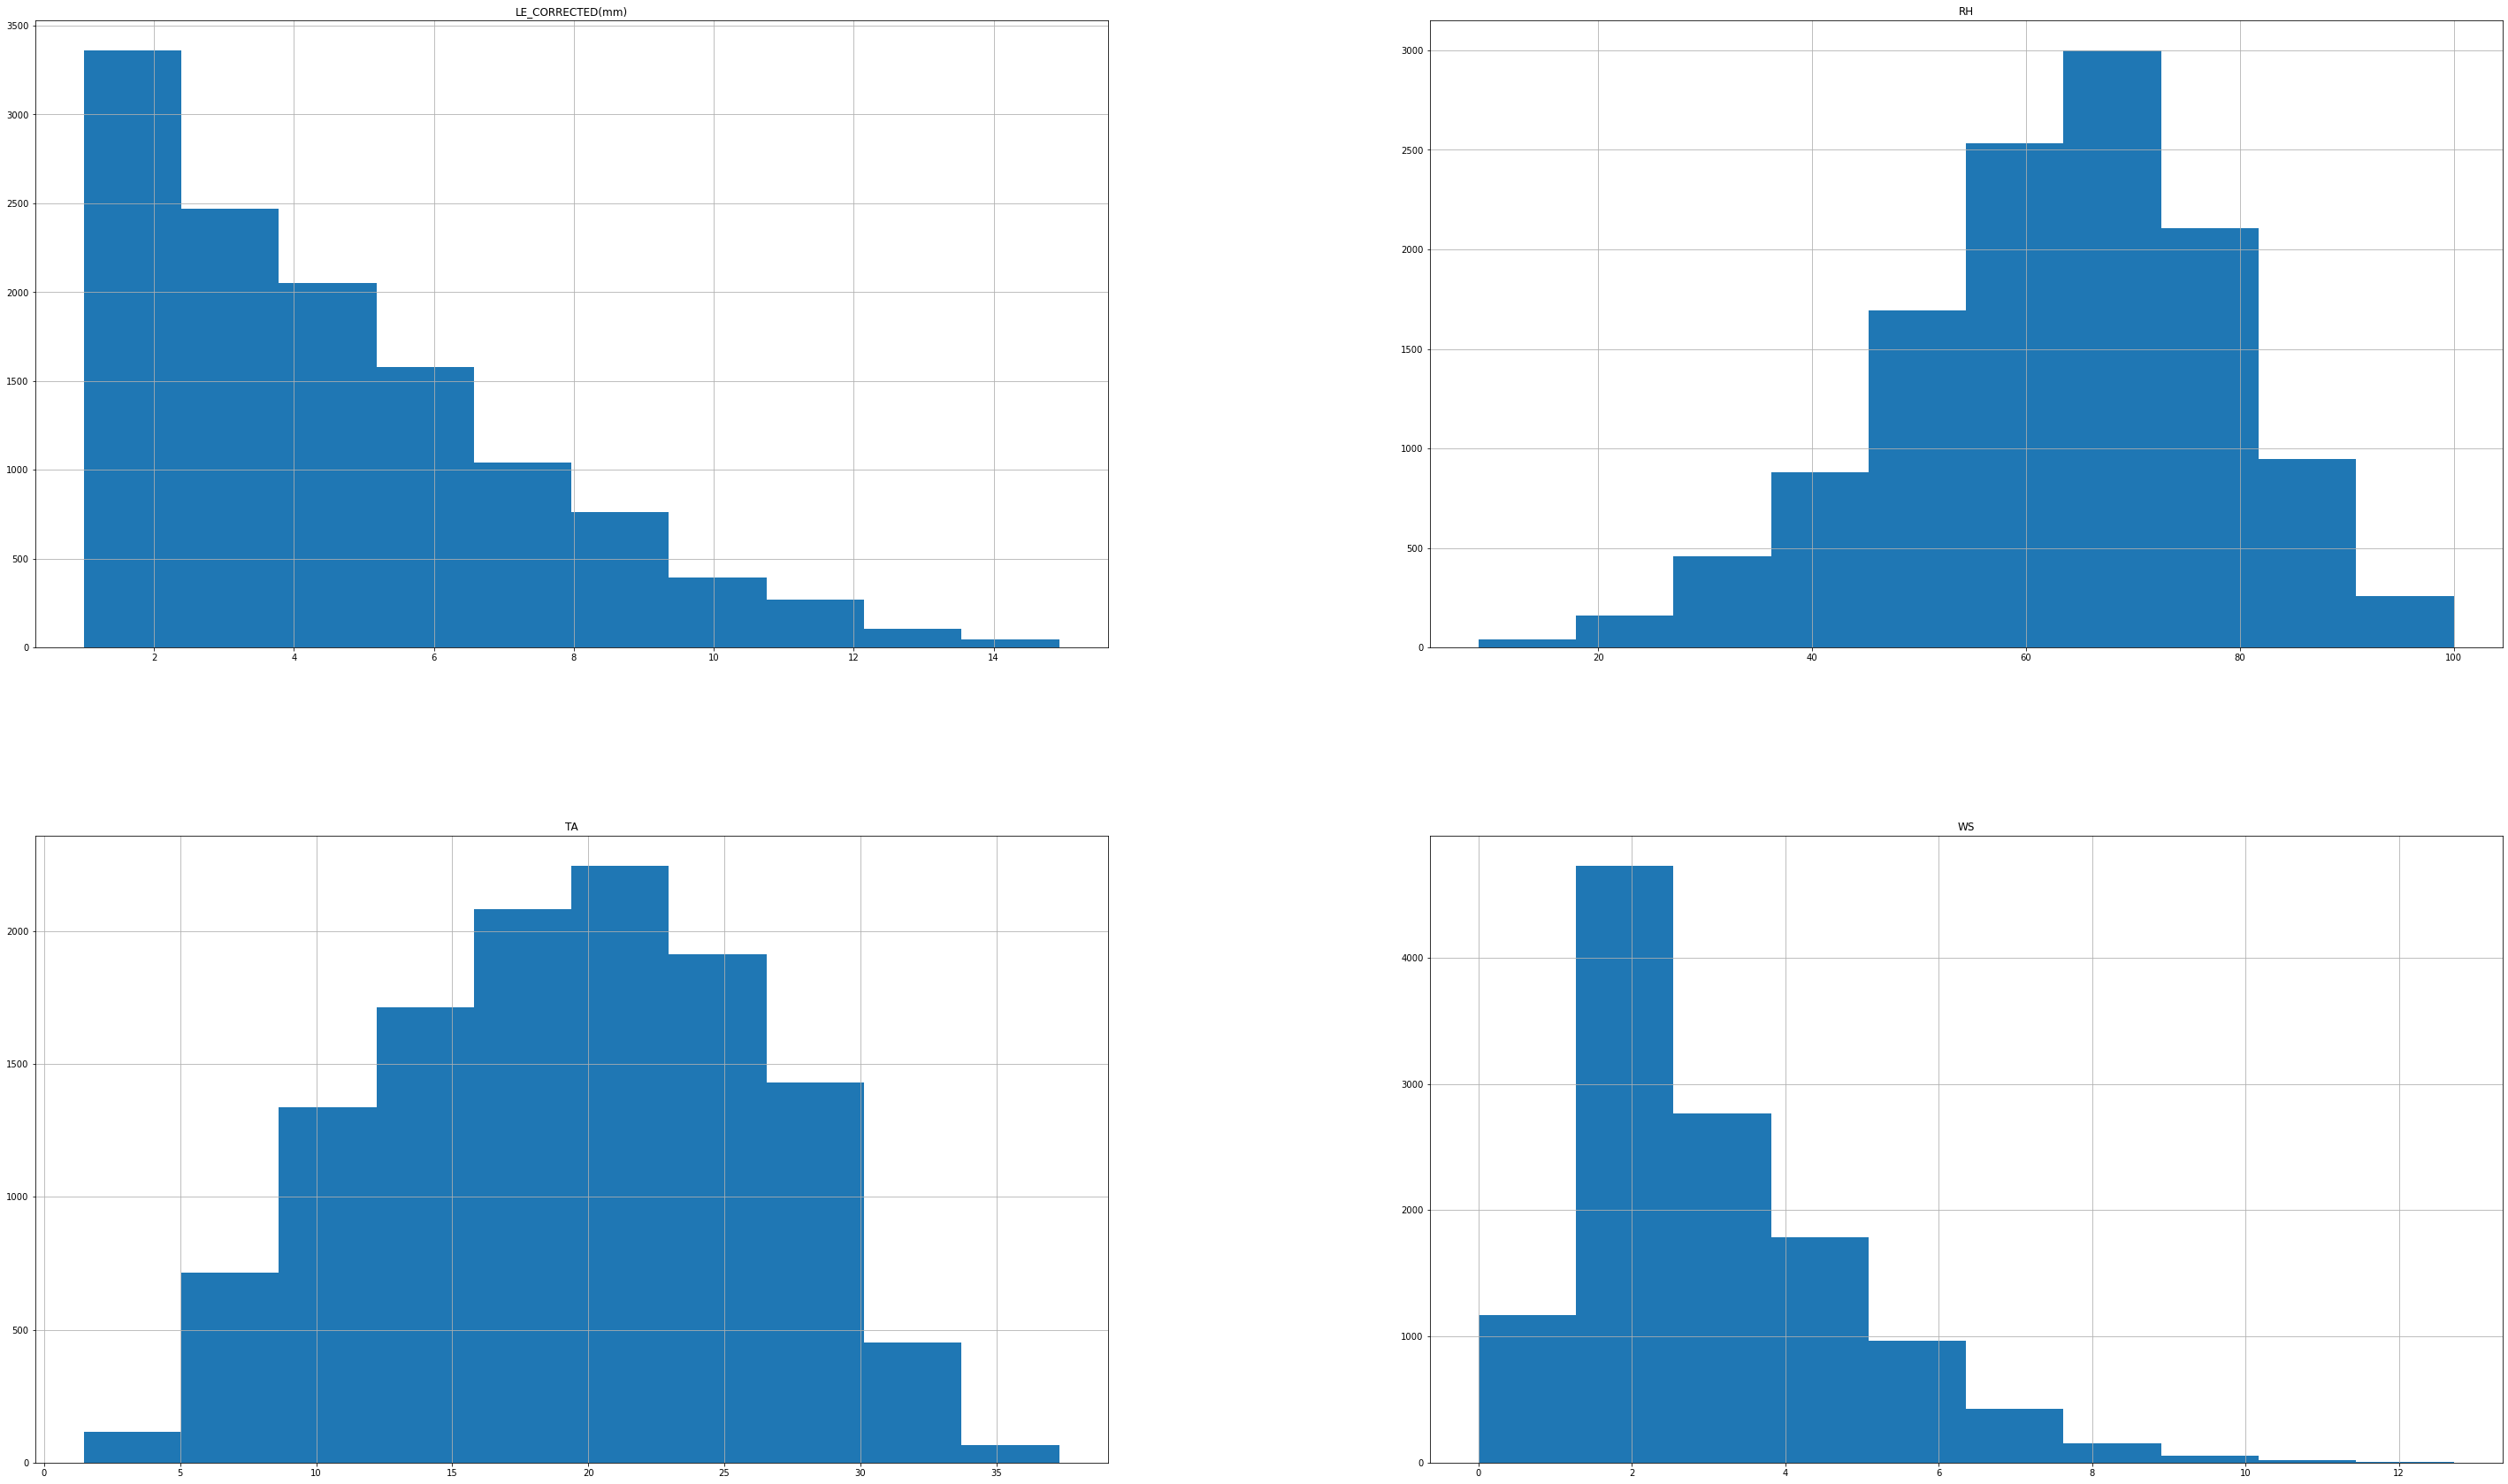

In [20]:
df_before = df.loc[:, all_columns]
df_before = df_before.replace([np.inf, -np.inf], np.nan)
df_before.hist(figsize=(50, 30)) 
pyplot.show()

<h3> After Scaling : Automatic </h3>

In [21]:
df_scaled = df_scaled_auto.replace([np.inf, -np.inf], np.nan)
df_scaled.hist(figsize=(50, 30)) 
pyplot.show()

NameError: name 'df_scaled_auto' is not defined

<h3> After Scaling : Manual </h3>

In [22]:
df_scaled = df_scaled_manual.replace([np.inf, -np.inf], np.nan)
df_scaled.hist(figsize=(50, 30)) 
pyplot.show()

AttributeError: 'NoneType' object has no attribute 'replace'

<h2> Redo Gaussian Test </h2>

In [23]:
#choose manual or automatic
manual = True

In [24]:
if manual:
    df_scaled = df_scaled_manual
else:
    df_scaled = df_scaled_auto
for i in all_columns: 
    #checking if data is Gaussian
    if not check_distribution_shapiro(df_scaled[i]) and not check_distribution_dagostino(df_scaled[i]):
        print(i + ' column still not Gaussian')
    if check_distribution_shapiro(df_scaled[i]) or check_distribution_dagostino(df_scaled[i]) : 
        print(i + ' column is now Gaussian')

TypeError: 'NoneType' object is not subscriptable

<h2> Export to csv </h2>

In [11]:
if manual:
    df_scaled = df_scaled_manual
else:
    df_scaled = df_scaled_auto
df_scaled.to_csv('C:\\Users\\Yasmine\\Agriculture\\df_scaled.csv')

<h2> Apply simple regression model </h2>

<b> Helper Methods </b>

In [25]:
def calculate_errors(actual,predicted):
    r2score = r2_score(actual,predicted)
    mase = mean_absolute_error(actual,predicted)
    rms = sqrt(mean_squared_error(actual,predicted))
    mse = mean_squared_error(actual,predicted)
    re = (mse / np.mean(predicted)) * 100
    pearson, pval = stats.pearsonr(actual.ravel(),predicted.ravel())
    mae = np.mean(np.abs((actual - predicted) / actual)) * 100
    return r2score,mase,rms,mse,re,pearson,pval,mae

def fit_predict(X_train_scaled,X_test_scaled,y_train):
    model = SVR(kernel='linear')
    model.fit(X_train_scaled,y_train)
    pred_y = model.predict(X_test_scaled)
    return pred_y, model
    
def error_metrics(y_test,y_pred):
    r2score,mase,rms,mse,re,pearson,pval,mae = calculate_errors(y_test,y_pred)
    print("The range for the output variable is:" + str(y_test.mean()))
    print("r2score : " + str(r2score))
    print("mae : " + str(mase))
    print("rmse : " + str(rms))
    print("mse : " + str(mse))
    print("re : " + str(re))
    print("pearson : " + str(pearson))
    print("mape : " + str(mae))
    
def evaluate(df, actual, predicted, thresh, rel_method='extremes', extr_type='high', coef=1.5, relevance_pts=None):
    y = np.array(df[actual])
    phi_params, loss_params, _ = get_phi_loss_params(y, rel_method, extr_type, coef, relevance_pts)

    nb_columns = len(list(df.columns.values)) - 1

    get_stats(df[actual], df[predicted], nb_columns, thresh, phi_params, loss_params)


def get_phi_loss_params(y, rel_method, extr_type='high', coef=1.5, relevance_pts=None):
    '''
    get the parameters of the relevance function
    :param df: dataframe being used
    :param target_variable: name of the target variable
    :param rel_method: either 'extremes' or 'range'
    :param extr_type: either 'high', 'low', or 'both' (defualt)
    :param coef: default: 1.5
    :param relevance_pts: the relevance matrix in case rel_method = 'range'
    :return: phi parameters and loss parameters
    '''

    if relevance_pts is None:
        print('WILL NOT USE RELEVANCE MATRIX')
        params = runit.get_relevance_params_extremes(y, rel_method=rel_method, extr_type=extr_type, coef=coef)
    else:
        print('USING RELEVANCE MATRIX')
        params = runit.get_relevance_params_range(y, rel_method=rel_method, extr_type=extr_type, coef=coef, relevance_pts=relevance_pts)

    # phi params and loss params
    phi_params = params[0]
    loss_params = params[1]
    relevance_values = params[2]

    phi_params = dict(zip(phi_params.names, list(phi_params)))
    loss_params = dict(zip(loss_params.names, list(loss_params)))

    return phi_params, loss_params, relevance_values


def get_stats(y_test, y_pred, nb_columns, thr_rel, phi_params, loss_params):
    '''
    Function to compute regression error metrics between actual and predicted values +
    correlation between both using different methods: Pearson, Spearman, and Distance
    :param y_test: the actual values. Example df['actual'] (the string inside is the name
    of the actual column. Example: df['LE (mm)'], df['demand'], etc.)
    :param y_pred: the predicted vlaues. Example df['predicted']
    :param nb_columns: number of columns <<discarding the target variable column>>
    :return: R2, Adj-R2, RMSE, MSE, MAE, MAPE
    '''

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    if not isinstance(y_test, list):
        y_test = list(y_test)
    if not isinstance(y_pred, list):
        y_pred = list(y_pred)

    n = len(y_test)

    r2_Score = r2_score(y_test, y_pred) # r-squared
    adjusted_r2 = 1 - ((1 - r2_Score) * (n - 1)) / (n - nb_columns - 1) # adjusted r-squared
    rmse_score = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE
    mse_score = mean_squared_error(y_test, y_pred) # MSE
    mae_score = mean_absolute_error(y_test, y_pred) # MAE
    mape_score = mean_absolute_percentage_error(y_test, y_pred) # MAPE

    trues = np.array(y_test)
    preds = np.array(y_pred)

    method = phi_params['method']
    npts = phi_params['npts']
    controlpts = phi_params['control.pts']
    ymin = loss_params['ymin']
    ymax = loss_params['ymax']
    tloss = loss_params['tloss']
    epsilon = loss_params['epsilon']

    rmetrics = runit.eval_stats(trues, preds, thr_rel, method, npts, controlpts, ymin, ymax, tloss, epsilon)

    # create a dictionary of the r metrics extracted above
    rmetrics_dict = dict(zip(rmetrics.names, list(rmetrics)))

    if isinstance(y_pred[0], np.ndarray):
        y_pred_new = [x[0] for x in y_pred]
        y_pred = y_pred_new
    pearson_corr, _ = pearsonr(y_test, y_pred)
    spearman_corr, _ = spearmanr(y_test, y_pred)
    distance_corr = distance.correlation(y_test, y_pred)

    print('\nUtility Based Metrics')
    print('F1: %.5f' % rmetrics_dict['ubaF1'][0])
    print('F2: %.5f' % rmetrics_dict['ubaF2'][0])
    print('F05: %.5f' % rmetrics_dict['ubaF05'][0])
    print('precision: %.5f' % rmetrics_dict['ubaprec'][0])
    print('recall: %.5f' % rmetrics_dict['ubarec'][0])

    print('\nRegression Error Metrics')
    print('R2: %.5f' % r2_Score)
    print('Adj-R2: %.5f' % adjusted_r2)
    print('RMSE: %.5f' % rmse_score)
    print('MSE: %.5f' % mse_score)
    print('MAE: %.5f' % mae_score)
    print('MAPE: %.5f' % mape_score)

    print('\nCorrelations')
    print('Pearson: %.5f' % pearson_corr)
    print('Spearman: %.5f' % spearman_corr)
    print('Distance: %.5f' % distance_corr)

Modeling

In [6]:
utility_based = False
y_pred, model = fit_predict(X_train_scaled,X_test_scaled,y_train)
df_scaled_test = X_test_scaled

#combine y_test and y_pred in 1 dataset
df_scaled_test['LE_ebr_corr(mm)'] = y_test
df_scaled_test['LE_ebr_corr(mm)_pred'] = y_pred

if utility_based == False:
    error_metrics(y_test,y_pred)
else:
    evaluate(df_scaled_test, actual='LE_ebr_corr(mm)', predicted='LE_ebr_corr(mm)_pred',
             thresh=0.8, rel_method='extremes', extr_type='high',
             coef=1.5, relevance_pts=None)

The range for the output variable is:4.553287389266667
r2score : 0.49329756184997553
mae : 1.5128736787974357
rmse : 1.985219693080037
mse : 3.941097229792796
re : 90.31126414186791
pearson : 0.706751730433375
mape : 46.75400050412824


# Interpretability 

<b> ELI5 </b>

In [7]:
import eli5

Using TensorFlow backend.


Global Interpretation: Look at a model’s parameters and figure out at a global level how the model works

In [8]:
eli5.show_weights(model)

On a local level: Look at a single prediction and identify features leading to that prediction

In [9]:
eli5.show_prediction(model, X_test.iloc[1], feature_names = list(X.columns)) 
# clf is the model fitted 
# X_train.iloc[1] is the record at index 1
# feature_names is the list of column names/features

<b> Lime </b>

In [10]:
import lime
import lime.lime_tabular

In [11]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names=X_train.columns)

# np.array(X_train): The training data
# class_names: The target variable(for regression), different classes in the target variable(for regression)
# categorical_features: List of all the column names which are categorical
# mode: For a regression problem: 'regression', and for a classification problem, 'classification

In [12]:
X_observation = X_test.iloc[[1], :]
explanation = explainer.explain_instance(X_observation.values[0], model.predict)
explanation.show_in_notebook(show_table=True, show_all=False)

Each feature’s contribution to this prediction is shown in the right bar plot. Orange signifies the positive impact and blue signifies the negative impact of that feature on the target. 

<b> SHAP </b>

The ‘SHapley Additive exPlanations’ Python library, better knows as the SHAP library, is one of the most popular libraries for machine learning interpretability. The SHAP library uses Shapley values at its core and is aimed at explaining individual predictions. The best part about SHAP is that it offers a special module for tree-based models. https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d

In [13]:
import shap

# Need to load JS visualisation in the notebook
shap.initjs()

model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train_scaled, y_train)

#assuming we are using XGBoost
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_scaled)

shap.force_plot(explainer.expected_value, shap_values[1], features=X_train_scaled.loc[1], 
feature_names=X_train_scaled.columns)
# i: id of the individual record

The output value is the prediction for that observation 
The base value is “the value that would be predicted if we did not know any features for the current output.” In other words, it is the mean prediction
Red/blue: Features that push the prediction higher (to the right) are shown in red, and those pushing the prediction lower are in blue.



<b> Yellow Brick </b>

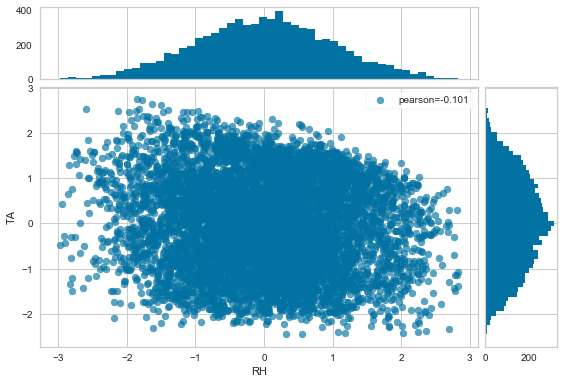

In [76]:
from yellowbrick.features import JointPlotVisualizer

visualizer = JointPlotVisualizer(columns= ['RH' , 'TA'])
visualizer.fit_transform(X_train_scaled, y_train)
visualizer.show()

# col1 and col2 are the 2 columns we want to explore.
# X is the independent variables
# y is the target variable

<b>Lucid </b>

The Lucid library aims to fill this void by providing tools for visualizing neural networks.

In [16]:
import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform

#Lucid does not support TF 2.0 at present.

#loading the model
model = models.InceptionV1()
model.load_graphdef()

# Visualising the neuron
_ = render.render_vis(model, layer)

#layer can be any layer in your Inception model like con1d, conv2d, maxpool10, etc.

<b> Alibi </b>

Alibi is an open-source Python library based on instance-wise explanations of predictions (instance, in this case, means individual data-points).  the library offers different types of Explainer models based on different techniques. While we won’t go into detail about each of them, it is important to note that the library is specifically designed for black-box models. Essentially, you just need the model predictions at the end to use the library. This is particularly useful when we won’t want to tamper with the workflow of our machine learning model.

The explainers:

Anchors --> classification	
CEM 	---> NN 

Counterfactual Instances ---> NN	
Kernel SHAP ---> Regression